# Focusing Properties of a Binary-Phase Zone Plate

It is also possible to compute a [near-to-far field transformation](https://meep.readthedocs.io/en/latest/Python_User_Interface/#near-to-far-field-spectra) in cylindrical coordinates. This is demonstrated in this example for a binary-phase [zone plate](https://en.wikipedia.org/wiki/Zone_plate) which is a rotationally-symmetric diffractive lens used to focus a normally-incident planewave to a single spot.

Using [scalar theory](http://zoneplate.lbl.gov/theory), the radius of the $n$<sup>th</sup> zone can be computed as:

<center>
$$ r_n^2 = n\lambda (f+\frac{n\lambda}{4})$$
</center>

where $n$ is the zone index (1,2,3,...,$N$), $f$ is the focal length, and $\lambda$ is the operating wavelength. The main design variable is the number of zones $N$. The design specifications of the zone plate are similar to the binary-phase grating in [Tutorial/Mode Decomposition/Diffraction Spectrum of a Binary Grating](https://meep.readthedocs.io/en/latest/Python_Tutorials/Mode_Decomposition/#diffraction-spectrum-of-a-binary-grating) with refractive index of 1.5 (glass), $\lambda$ of 0.5 μm, and height of 0.5 μm. The focusing property of the zone plate is verified by the concentration of the electric-field energy density at the focal length of 0.2 mm (which lies *outside* the cell). The planewave is incident from within a glass substrate and spans the entire length of the cell in the radial direction. The cell is surrounded on all sides by PML. A schematic of the simulation geometry for a design with 25 zones and flat-surface termination is shown below. The near-field line monitor is positioned at the edge of the PML.

![](https://meep.readthedocs.io/en/latest/images/zone_plate_schematic.png)

In [1]:
import math

import matplotlib.pyplot as plt
import meep as mp
import numpy as np


resolution_um = 25

pml_um = 1.0
substrate_um = 2.0
padding_um = 2.0
height_um = 0.5
focal_length_um = 200
scan_length_z_um = 100
farfield_resolution_um = 10

pml_layers = [mp.PML(thickness=pml_um)]

wavelength_um = 0.5
frequency = 1 / wavelength_um
frequench_width = 0.2 * frequency

# The number of zones in the zone plate.                                                                          
# Odd-numbered zones impart a π phase shift and                                                                   
# even-numbered zones impart no phase shift.                                                                      
num_zones = 25

# Specify the radius of each zone using the equation                                                              
# from https://en.wikipedia.org/wiki/Zone_plate.                                                                  
zone_radius_um = np.zeros(num_zones)
for n in range(1, num_zones + 1):
    zone_radius_um[n - 1] = math.sqrt(
        n * wavelength_um * (focal_length_um + n * wavelength_um / 4)
    )

size_r_um = zone_radius_um[-1] + padding_um + pml_um
size_z_um = pml_um + substrate_um + height_um + padding_um + pml_um
cell_size = mp.Vector3(size_r_um, 0, size_z_um)

# Specify a (linearly polarized) planewave at normal incidence.                                                   
sources = [
    mp.Source(
        mp.GaussianSource(frequency, fwidth=frequench_width, is_integrated=True),
        component=mp.Er,
        center=mp.Vector3(0.5 * size_r_um, 0, -0.5 * size_z_um + pml_um),
        size=mp.Vector3(size_r_um),
    ),
    mp.Source(
        mp.GaussianSource(frequency, fwidth=frequench_width, is_integrated=True),
        component=mp.Ep,
        center=mp.Vector3(0.5 * size_r_um, 0, -0.5 * size_z_um + pml_um),
        size=mp.Vector3(size_r_um),
	amplitude=-1j,
    ),
]

glass = mp.Medium(index=1.5)

# Add the substrate.                                                                                              
geometry = [
    mp.Block(
        material=glass,
        size=mp.Vector3(size_r_um, 0, pml_um + substrate_um),
        center=mp.Vector3(
            0.5 * size_r_um, 0, -0.5 * size_z_um + 0.5 * (pml_um + substrate_um)
        ),
    )
]

# Add the zone plates starting with the ones with largest radius.                                                 
for n in range(num_zones - 1, -1, -1):
    geometry.append(
        mp.Block(
            material=glass if n % 2 == 0 else mp.vacuum,
            size=mp.Vector3(zone_radius_um[n], 0, height_um),
            center=mp.Vector3(
                0.5 * zone_radius_um[n],
                0,
                -0.5 * size_z_um + pml_um + substrate_um + 0.5 * height_um,
            ),
        )
    )

sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    resolution=resolution_um,
    sources=sources,
    geometry=geometry,
    dimensions=mp.CYLINDRICAL,
    m=-1,
)

# Add the near-field monitor (must be entirely in air).                                                           
n2f_monitor = sim.add_near2far(
    frequency,
    0,
    1,
    mp.Near2FarRegion(
        center=mp.Vector3(0.5 * (size_r_um - pml_um), 0, 0.5 * size_z_um - pml_um),
        size=mp.Vector3(size_r_um - pml_um, 0, 0),
    ),
    mp.Near2FarRegion(
        center=mp.Vector3(
            size_r_um - pml_um,
            0,
            0.5 * size_z_um - pml_um - 0.5 * (height_um + padding_um),
        ),
        size=mp.Vector3(0, 0, height_um + padding_um),
    ),
)

Using MPI version 3.1, 1 processes


     block, center = (26.6946,0,-1.75)
          size (53.3891,0,3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (25.1946,0,0)
          size (50.3891,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (24.6779,0,0)
          size (49.3559,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (24.1509,0,0)
          size (48.3018,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (23.6128,0,0)
          size (47.2255,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (23.0628,0,0)
          size (46.1255,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagon

<AxesSubplot:xlabel='R', ylabel='Z'>

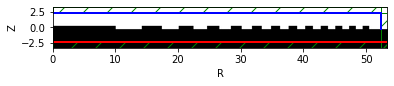

In [2]:
fig, ax = plt.subplots()
sim.plot2D(ax=ax)

In [3]:
# Timestep the fields until they have sufficiently decayed away.                                                  
sim.run(
    until_after_sources=mp.stop_when_fields_decayed(
        50.0, mp.Er, mp.Vector3(0.5 * size_r_um, 0, 0), 1e-6
    )
)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00028924 s
Working in Cylindrical dimensions.
Computational cell is 53.4 x 0 x 6.52 with resolution 25
     block, center = (26.6946,0,-1.75)
          size (53.3891,0,3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (25.1946,0,0)
          size (50.3891,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (24.6779,0,0)
          size (49.3559,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (24.1509,0,0)
          size (48.3018,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (23.6128,0,0)
          size (47.2255,0,0.5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant eps

In [4]:
farfields_r = sim.get_farfields(
    n2f_monitor,
    farfield_resolution_um,
    center=mp.Vector3(
        0.5 * (size_r_um - pml_um),
        0,
        -0.5 * size_z_um + pml_um + substrate_um + height_um + focal_length_um,
    ),
    size=mp.Vector3(size_r_um - pml_um, 0, 0),
)

farfields_z = sim.get_farfields(
    n2f_monitor,
    farfield_resolution_um,
    center=mp.Vector3(
        0, 0, -0.5 * size_z_um + pml_um + substrate_um + height_um + focal_length_um
    ),
    size=mp.Vector3(0, 0, scan_length_z_um),
)

get_farfields_array working on point 44 of 523 (8% done), 0.0923484 s/point
get_farfields_array working on point 75 of 523 (14% done), 0.133575 s/point
get_farfields_array working on point 100 of 523 (19% done), 0.16357 s/point
get_farfields_array working on point 120 of 523 (22% done), 0.207044 s/point
get_farfields_array working on point 138 of 523 (26% done), 0.229834 s/point
get_farfields_array working on point 155 of 523 (29% done), 0.246436 s/point
get_farfields_array working on point 171 of 523 (32% done), 0.258188 s/point
get_farfields_array working on point 186 of 523 (35% done), 0.267175 s/point
get_farfields_array working on point 201 of 523 (38% done), 0.279909 s/point
get_farfields_array working on point 214 of 523 (40% done), 0.312383 s/point
get_farfields_array working on point 226 of 523 (43% done), 0.336642 s/point
get_farfields_array working on point 238 of 523 (45% done), 0.360156 s/point
get_farfields_array working on point 249 of 523 (47% done), 0.375252 s/point
ge

Text(0.5, 0.98, 'binary-phase zone plate with focal length $z$ = 200 μm')

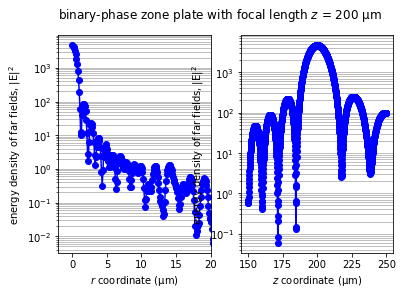

In [5]:
intensity_r = (
    np.absolute(farfields_r["Ex"]) ** 2
    + np.absolute(farfields_r["Ey"]) ** 2
    + np.absolute(farfields_r["Ez"]) ** 2
)
intensity_z = (
    np.absolute(farfields_z["Ex"]) ** 2
    + np.absolute(farfields_z["Ey"]) ** 2
    + np.absolute(farfields_z["Ez"]) ** 2
)

# Plot the intensity data and save the result to disk.                                                            
fig, ax = plt.subplots(ncols=2)

ax[0].semilogy(np.linspace(0, size_r_um - pml_um, intensity_r.size), intensity_r, "bo-")
ax[0].set_xlim(-2, 20)
ax[0].set_xticks(np.arange(0, 25, 5))
ax[0].grid(True, axis="y", which="both", ls="-")
ax[0].set_xlabel(r"$r$ coordinate (μm)")
ax[0].set_ylabel(r"energy density of far fields, |E|$^2$")

ax[1].semilogy(
    np.linspace(
        focal_length_um - 0.5 * scan_length_z_um,
        focal_length_um + 0.5 * scan_length_z_um,
        intensity_z.size,
    ),
    intensity_z,
    "bo-",
)
ax[1].grid(True, axis="y", which="both", ls="-")
ax[1].set_xlabel(r"$z$ coordinate (μm)")
ax[1].set_ylabel(r"energy density of far fields, |E|$^2$")

fig.suptitle(f"binary-phase zone plate with focal length $z$ = {focal_length_um} μm")

Note that the volume specified in `get_farfields` via `center` and `size` is in cylindrical coordinates. These points must therefore lie in the $\phi = 0$ ($rz = xz$) plane. The fields $E$ and $H$ returned by `get_farfields` can be thought of as either cylindrical ($r$,$\phi$,$z$) or Cartesian ($x$,$y$,$z$) coordinates since these are the same in the $\phi = 0$ plane (i.e., $E_r=E_x$ and $E_\phi=E_y$). Also, `get_farfields` tends to gradually *slow down* as the far-field point gets closer to the near-field monitor. This performance degradation is unavoidable and is due to the larger number of $\phi$ integration points required for accurate convergence of the integral involving the Green's function which diverges as the evaluation point approaches the source point.

Shown below is the far-field energy-density profile around the focal length for both the *r* and *z* coordinate directions for three lens designs with $N$ of 25, 50, and 100. The focus becomes sharper with increasing $N$ due to the enhanced constructive interference of the diffracted beam. As the number of zones $N$ increases, the size of the focal spot (full width at half maximum) at $z = 200$ μm decreases as $1/\sqrt{N}$ (see eq. 17 of the [reference](http://zoneplate.lbl.gov/theory)). This means that doubling the resolution (halving the spot width) requires quadrupling the number of zones.

![](https://meep.readthedocs.io/en/latest/images/zone_plate_farfield.png)